In [ ]:
!pip install kaggle
from google.colab import files 
#files.open('/content/drive/MyDrive/Colab Notebooks/json kaggle')
files.upload() #download and upload json file



!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d samratalam/stemmed-20-times-dataset

100% 62.0M/62.2M [00:02<00:00, 17.4MB/s]
100% 62.2M/62.2M [00:02<00:00, 30.1MB/s]


In [ ]:
#to unzip file

from zipfile import ZipFile
file_name= "stemmed-20-times-dataset.zip"

with ZipFile(file_name ,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
import pandas as pd
from pandas import read_excel
import numpy as np
import re
from re import sub
import multiprocessing
#from unidecode import unidecode
import os
from time import time 
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Activation,Embedding,Flatten,Bidirectional,MaxPooling2D, Conv1D, MaxPooling1D
from keras.optimizers import SGD,Adam
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import h5py
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [ ]:
'''
!pip install wandb
import wandb
wandb.init()
'''

'\n!pip install wandb\nimport wandb\nwandb.init()\n'

In [ ]:
df=pd.read_csv('/content/strem_20_times_data_clen.csv')

df.drop(columns=['Unnamed: 0'],inplace=True)
display(df)

,Sentence,Sentiment,length
0,গ্রেগর সামসা সেলস্ম্যান সকাল ঘুম উঠ তেলাপোকা ব...,2,45477
1,গ্রেগর সামসা সেলস্ম্যান সকাল ঘুম উঠ তেলাপোকা ব...,1,45477
2,জাতী সংসদ বাজেট আলোচনা বিরোধীদলী নেতা দেশনেত্র...,4,33176
3,জাতী সংসদ বাজেট আলোচনা বিরোধীদলী নেতা দেশনেত্র...,8,33176
4,জাতী সংসদ বাজেট আলোচনা বিরোধীদলী নেতা দেশনেত্র...,9,33176
...,...,...,...
95757,ঢাকা সেপ্ট,4,10
95758,মারুফ মল্,6,9
95759,মারুফ মল্,6,9
95760,লਫন৴ োম,2,7


In [ ]:
df.iloc[95119]['Sentence']

'প্রি শিক্ষার্থী ইংরেজি পত্র নং প্রশ্ন প্রশ্ন শূন্যস্থান পূরণ নম্বর প্রভাষক ঢাকা রেসিডেনসিয়াল মড কলেজ'

# **Dataframe Null value **

In [ ]:
df.loc[df['length'] <= 100]

,Sentence,Sentiment,length
95117,ইংরেজি পত্র লেসন প্রি শিক্ষার্থী ইংরেজি পত্র ল...,4,100
95118,প্রি শিক্ষার্থী ইংরেজি পত্র নম্বর প্রশ্ন আলোচন...,4,100
95119,প্রি শিক্ষার্থী ইংরেজি পত্র নং প্রশ্ন প্রশ্ন শ...,4,100
95120,প্রি শিক্ষার্থী ইংরেজি পত্র চর্চা কর মি নেব শি...,4,100
95121,রিয়াজুল বাশ মাহমুদ শরীফ বিডিনিউজ টোয়েন্টিফোর ড...,6,100
...,...,...,...
95757,ঢাকা সেপ্ট,4,10
95758,মারুফ মল্,6,9
95759,মারুফ মল্,6,9
95760,লਫন৴ োম,2,7


In [ ]:
df.drop(df[df['length'] < 100].index, inplace = True)
display(df)

,Sentence,Sentiment,length
0,গ্রেগর সামসা সেলস্ম্যান সকাল ঘুম উঠ তেলাপোকা ব...,2,45477
1,গ্রেগর সামসা সেলস্ম্যান সকাল ঘুম উঠ তেলাপোকা ব...,1,45477
2,জাতী সংসদ বাজেট আলোচনা বিরোধীদলী নেতা দেশনেত্র...,4,33176
3,জাতী সংসদ বাজেট আলোচনা বিরোধীদলী নেতা দেশনেত্র...,8,33176
4,জাতী সংসদ বাজেট আলোচনা বিরোধীদলী নেতা দেশনেত্র...,9,33176
...,...,...,...
95125,জয়পুর জুন বিডিনিউজ টোয়েন্টিফোর ডটকমরয়টার্স চাক...,4,100
95126,ইউনিট লেসন প্রি শিক্ষার্থী ইংরেজি পত্র গতকাল ই...,4,100
95127,ইউনিট লেসন প্রিয় শিক্ষার্থী ইংরেজি পত্র ইউনিট...,4,100
95128,প্রি শিক্ষার্থী ইংরেজি পত্র নং প্রশ্ন আলোচনা ...,4,100


In [ ]:
df = df.drop_duplicates('Sentence', keep='first')

df.reset_index(inplace=True)
df.drop(columns=['index'],inplace=True)
df

,Sentence,Sentiment,length
0,গ্রেগর সামসা সেলস্ম্যান সকাল ঘুম উঠ তেলাপোকা ব...,2,45477
1,জাতী সংসদ বাজেট আলোচনা বিরোধীদলী নেতা দেশনেত্র...,4,33176
2,ঢাকা শহর আতঙ্ক শহর দিনরাত সবখান মৃত্যুর অশুভ ছ...,1,31688
3,এটিএন বাংলা ঈদ অনুষ্ঠানমালা ছয়দিন দশ পর্ব নাটক...,11,26534
4,কথা কথা কথা পাব অ্যাকটিং ভালো রপ্ত কর ওশোর পাত...,11,21860
...,...,...,...
88674,জয়পুর জুন বিডিনিউজ টোয়েন্টিফোর ডটকমরয়টার্স চাক...,4,100
88675,ইউনিট লেসন প্রি শিক্ষার্থী ইংরেজি পত্র গতকাল ই...,4,100
88676,ইউনিট লেসন প্রিয় শিক্ষার্থী ইংরেজি পত্র ইউনিট...,4,100
88677,প্রি শিক্ষার্থী ইংরেজি পত্র নং প্রশ্ন আলোচনা ...,4,100


In [ ]:
df.isna().sum().sum()

0

In [ ]:
df.dropna(axis=0, how="any", thresh=None, subset=None, inplace=True)

In [ ]:
df.isna().sum().sum()

0

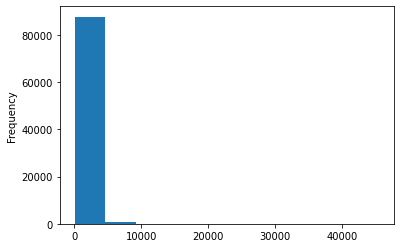

In [ ]:
df['Sentence'].apply(lambda x: len(str(x))).plot(kind='hist');

In [ ]:
df.Sentiment.reset_index(drop=True, inplace=True)

In [ ]:
df.Sentiment.value_counts()

9     18558
11    11296
4     10706
5      8951
2      8199
8      7684
0      6126
7      5036
6      3754
3      3389
10     2810
1      2170
Name: Sentiment, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


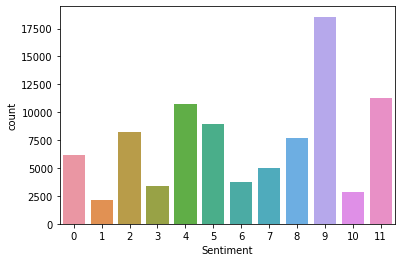

In [ ]:
sns.countplot(df['Sentiment']);

# **bnltk 0.7.6 Stemmer**

**New Stemmed**

In [ ]:
uniqueWords = list(set(" ".join(df['Sentence']).split(" ")))
count = len(uniqueWords)
print(count)

332301


In [ ]:
df['Sentence'] = df['Sentence'].astype('str') 
df.reset_index(drop=True, inplace=True)
#df['Sentence'] = df['Sentence'].astype('str')

In [ ]:

#df['Sentence'] = df.Sentence.apply(lambda x: Stemming(str(x)))

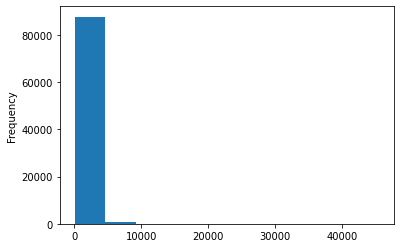

In [ ]:
df['Sentence'].apply(lambda x: len(str(x))).plot(kind='hist');

In [ ]:
from collections import Counter
#Counter(" ".join(df["Sentence"]).split()).most_common(1000)  
#NOT FASTER 

In [ ]:
#pd.Series(' '.join(df['Sentence']).lower().split()).value_counts()[:10000] #faster AND for large amounts of text/rows

# **Shuffle the data**

In [ ]:
from sklearn.utils import shuffle
df = shuffle(df)

In [ ]:
df.Sentiment.value_counts()

9     18558
11    11296
4     10706
5      8951
2      8199
8      7684
0      6126
7      5036
6      3754
3      3389
10     2810
1      2170
Name: Sentiment, dtype: int64

In [ ]:
train1, test1 = train_test_split(df,random_state=22, test_size=0.2)
training_sentences = []
testing_sentences = []




train_sentences=train1['Sentence'].values
train_labels=train1['Sentiment'].values
#for i in range(train_sentences.shape[0]): 
    #print(train_sentences[i])
 #   x=str(train_sentences[i])
 #   training_sentences.append(x)

 
    
#training_sentences=np.array(training_sentences)





test_sentences=test1['Sentence'].values
test_labels=test1['Sentiment'].values
#y = pd.get_dummies(data1['Sentiment']).values

train_labels=pd.get_dummies(train_labels).values
test_labels=pd.get_dummies(test_labels).values


print("Training Set Length: "+str(len(train1)))
print("Testing Set Length: "+str(len(test1)))
print("training_sentences shape: "+str(train_sentences.shape))
print("testing_sentences shape: "+str(test_sentences.shape))
print("train_labels shape: "+str(train_labels.shape))
print("test_labels shape: "+str(test_labels.shape))


Training Set Length: 70943
Testing Set Length: 17736
training_sentences shape: (70943,)
testing_sentences shape: (17736,)
train_labels shape: (70943, 12)
test_labels shape: (17736, 12)


In [ ]:
train_labels

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]], dtype=uint8)

In [ ]:
print(train_sentences[10])
print(train_labels[0])

বাংলাদেশ কৃষি ব্যাংক অর্ধেক আমানতকারী টাক হিসাবধারী লাখ আমানতকারী রয় টাক হিসাবধারী রয় লাখ গতকাল বুধব বিকেবির পাঠানো বিজ্ঞপ্তি তথ্য লাখ ব্যক্তি ব্যাংক ঋণ টাকা লাখ ক্ষুদ্র প্রান্তিক হতদরিদ্র বর্গাচাষি ঋণ টাকা কর্মসূচির আওতায় বস্তিবাসী পরিব লাখ টাকা ঋণ বিজ্ঞপ্তি খা ঋণ বিতরণ ব্যাংক শাখা কম্পিউটারাইজেশন অফলাইন ব্যাংকিং কার্যক্রম শাখায় অনলাইন এটিএম বুথ বিকেবির শাখা মোবাইল ব্যাংকিং কার্যক্রম
[0 0 0 0 0 0 0 0 0 0 0 1]


In [ ]:
vocab_size = 200000
embedding_dim = 300
max_length = 4000
trunc_type='post'
oov_tok = "<OOV>"

In [ ]:
print(train_sentences.shape)
print(train_labels.shape)

(70943,)
(70943, 12)


In [ ]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

#451606 words in raw dataset
#434245 words in raw dataset after stopwords removal
#339313 after stemming 

print(len(word_index))
print("Word index length:"+str(len(tokenizer.word_index)))
sequences = tokenizer.texts_to_sequences(train_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)


test_sequences = tokenizer.texts_to_sequences(test_sentences)
testing_padded = pad_sequences(test_sequences,maxlen=max_length)

292587
Word index length:292587


In [ ]:
print("Sentence :--> \n")
print(train_sentences[2]+"\n")
print("Sentence Tokenized and Converted into Sequence :--> \n")
print(str(sequences[2])+"\n")
print("After Padding the Sequence with padding length 100 :--> \n")
print(padded[2])

Sentence :--> 

দিল্লির এইচবিএস ইনস্টিটিউট অব লিভ অ্যান্ড বিলিয়ারি সায়েন্স হাসপাতাল সাংবাদিক বড় মা হামিম জহির বিডিনিউজ টোয়েন্টিফোর ডটকম বাব ভালো বৃহস্পতিব দুপুর আইসিইউ নেয়া বাবা লাইফ সাপোর্ট জন্ড ভুগ জহিরুল হক বঙ্গবন্ধু শেখ মুজিব মেডিক বিশ্ববিদ্যাল হাসপাতাল চিকিৎসাধীন সপ্তাহ দিল্ নেয়া বঙ্গবন্ধুর স্নেহভাজন জহিরুল ঢাকা হাসপাতাল আস প্রধানমন্ত্রী শেখ হাসিনা জহিরুল আরোগ্য কামনা ফটোজার্নালিস্ট অ্যাসোসিয়েশন বৃহস্পতিব বিকাল জাতী প্রেসক্লাব দোয়া মাহফিল আয়োজন জহিরুল হক কলকাত আজকাল পত্রিক বাংলাদেশ প্রতিনিধি হাসা দৈনিক জনকণ্ঠ দৈনিক আজাদ অবজারভ টাইমস বাংল বাণী

Sentence Tokenized and Converted into Sequence :--> 

[3284, 140864, 1020, 264, 6648, 363, 140865, 5052, 86, 75, 124, 30, 29266, 2619, 5, 6, 16, 1077, 92, 106, 67, 8579, 553, 445, 2676, 7410, 25837, 3247, 3910, 108, 266, 18, 1777, 304, 54, 86, 1461, 277, 1736, 553, 996, 41837, 3910, 11, 86, 60, 21, 18, 45, 3910, 14410, 1681, 53338, 2072, 106, 168, 43, 1086, 3031, 3554, 309, 3910, 108, 2320, 5754, 2216, 4, 310, 25, 1006, 13302, 1006, 801, 184

In [ ]:
print("Padded shape(training): "+str(padded.shape))
print("Padded shape(testing): "+str(testing_padded.shape))

Padded shape(training): (70943, 4000)
Padded shape(testing): (17736, 4000)


In [ ]:
from keras.layers import MaxPool1D
model= Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Conv1D(200, kernel_size=3, activation = "relu"))
model.add(MaxPool1D(pool_size=2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(50, activation='relu'))

#l2 regularizer
model.add(Dense(20,kernel_regularizer=regularizers.l2(0.01),activation="relu"))
#model.add(Flatten())
model.add(Dense(12, activation='softmax'))
#sgd= SGD(lr=0.0001,decay=1e-6,momentum=0.9,nesterov=True)
adam=Adam(learning_rate=0.0005,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False)
model.summary()
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

#CNN


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 4000, 300)         60000000  
_________________________________________________________________
conv1d (Conv1D)              (None, 3998, 200)         180200    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1999, 200)         0         
_________________________________________________________________
dropout (Dropout)            (None, 1999, 200)         0         
_________________________________________________________________
flatten (Flatten)            (None, 399800)            0         
_________________________________________________________________
dense (Dense)                (None, 50)                19990050  
_________________________________________________________________
dense_1 (Dense)              (None, 20)                1

In [ ]:
history=model.fit(padded,train_labels,epochs=5,batch_size=128,validation_data=(testing_padded,test_labels),use_multiprocessing=True, workers=8)

Epoch 1/5
555/555 [==============================] - 819s 1s/step - loss: 1.9297 - accuracy: 0.4324 - val_loss: 0.7953 - val_accuracy: 0.7972
Epoch 2/5
555/555 [==============================] - 771s 1s/step - loss: 0.5478 - accuracy: 0.8631 - val_loss: 0.5957 - val_accuracy: 0.8475
Epoch 3/5
555/555 [==============================] - 770s 1s/step - loss: 0.2434 - accuracy: 0.9483 - val_loss: 0.6464 - val_accuracy: 0.8410
Epoch 4/5
555/555 [==============================] - 769s 1s/step - loss: 0.1264 - accuracy: 0.9770 - val_loss: 0.7160 - val_accuracy: 0.8381
Epoch 5/5
555/555 [==============================] - 777s 1s/step - loss: 0.0741 - accuracy: 0.9896 - val_loss: 0.8770 - val_accuracy: 0.8347


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


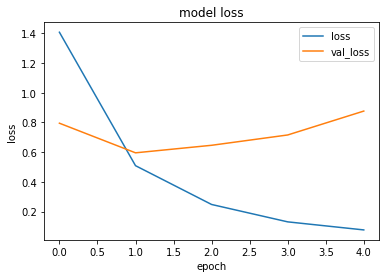

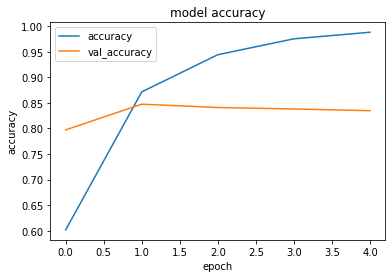

In [ ]:
print(history.history.keys())
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'])
plt.show()

accuracy = history.history['accuracy']
val_accuracy= history.history['val_accuracy']
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [ ]:
#accuracy calculation
loss_and_metrics = model.evaluate(padded,train_labels,batch_size=128)
print("The train accuracy is: "+str(loss_and_metrics[1]))
loss_and_metrics = model.evaluate(testing_padded,test_labels,batch_size=128)
print("The test accuracy is: "+str(loss_and_metrics[1]))

555/555 [==============================] - 172s 310ms/step - loss: 0.0489 - accuracy: 0.9954
The train accuracy is: 0.9953624606132507
139/139 [==============================] - 43s 310ms/step - loss: 0.8770 - accuracy: 0.8347
The test accuracy is: 0.8346865177154541


In [ ]:
predictions = model.predict(testing_padded)
pred1 = np.argmax(predictions , axis=1)

In [ ]:
%%time
score = model.evaluate(testing_padded, test_labels , batch_size = 128)
print()

print("ACCURACY:",score[1])
print("LOSS:",score[0])

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
test_labels = np.argmax(test_labels,axis=1)

In [ ]:
print(confusion_matrix(test_labels , pred1 ,normalize=None))

In [ ]:
print(classification_report(test_labels , pred1,digits=5))

              precision    recall  f1-score   support

           0    0.90835   0.87886   0.89336      1263
           1    0.48307   0.47768   0.48036       448
           2    0.79663   0.87380   0.83343      1569
           3    0.83871   0.80456   0.82128       614
           4    0.86151   0.79854   0.82883      2189
           5    0.80295   0.85378   0.82759      1785
           6    0.79392   0.62667   0.70045       750
           7    0.85402   0.83012   0.84190      1036
           8    0.81415   0.75160   0.78162      1562
           9    0.82985   0.90689   0.86666      3630
          10    0.79820   0.76910   0.78338       576
          11    0.92646   0.90925   0.91778      2314

    accuracy                        0.83469     17736
   macro avg    0.80898   0.79007   0.79805     17736
weighted avg    0.83533   0.83469   0.83369     17736



In [ ]:
accuracy_score(test_labels , pred1)

0.8346865133062698